<center><h1>Forest Cover Classification</h1></center>
<center><h3>Step 6. Model Evaluation</h3></center>
<center><img src="https://raw.githubusercontent.com/oliver-m-king/forest_cover_classification/main/tree_image.png" alt="Image byFreepik" width="500" height="500"></center>

<h3>The dataset</h3>

This dataset contains observations of a selection of geographic data on 30 x 30 meter cells located in the Roosevelt National Forest of northern Colorado.<br>
There are 581,012 observations of 12 independent variables.<br>
The aim of this project is to develop a model that can accurately predict what type of forest cover a 30m x 30m cell in any area <i>similar</i> to the Roosevelt National Forest has, based on measurements of it's elevation; aspect; distance to water, roads and firepoints; hillshade; and soil type.

Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data.

The dataset was sourced from the <a href="https://archive.ics.uci.edu/ml/datasets/Covertype">Center for Machine Learning and Intelligent Systems, University of California Irvine</a>

<i>Image by Freepik</i>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
#from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score, balanced_accuracy_score, precision_score
#from sklearn.metrics import recall_score, jaccard_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow import keras

# Define a color list for plotting
color_list = ["#68c4a4", "#ff8c64", "#90a4cc", "#e88cc4", "#ffdc2c", "#a8dc54", "#e8c494"]

# Define directory
data_dir = "C:\\Users\\oliki\\OneDrive\\Forest Cover Classification\\"

# Define cover_types in English
cover_types = ["spruce_fir", "lodgepole_pine", "ponderosa_pine", "cottonwood_willow", "aspen", "douglas_fir", "krummholz"]

<h3>Extract data and perform train-test split</h3>

The data with polynomial features is imported, and a Stratified Shuffle Split is performed using the same random state as was used in the <i>Model Definition and Training</i> phases.

In [2]:
# Import data
file_name = "X.pkl"
X = pd.read_pickle(data_dir + file_name)

file_name = "X_poly.pkl"
poly_X = pd.read_pickle(data_dir + file_name)

file_name = "y.pkl"
y = pd.read_pickle(data_dir + file_name)

In [3]:
# Create train-test splits for data with and without polynomial features
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=123)
 
for train_index, test_index in sss.split(poly_X, y):
    poly_X_train = poly_X[poly_X.index.isin(train_index)]
    poly_X_test = poly_X[poly_X.index.isin(test_index)]
    poly_y_train = y[y.index.isin(train_index)]
    poly_y_test = y[y.index.isin(test_index)]

<h3>Load the model and re-predict on the test data</h3>

The model saved at the end of the <i>Model Definition and Training</i> phases is loaded, and predictions and probablities are made using the X test data.

In [4]:
# Load the model
file_name = "nn_with_poly"
model_nn = keras.models.load_model(data_dir + file_name)

# Predict
y_pred_probs = model_nn.predict(poly_X_test)
y_pred = []
for row in y_pred_probs:
    row_list = row.tolist()
    max_index = row_list.index(max(row_list))
    y_pred.append(max_index + 1)

In [5]:
# Create lists of probs for each cover_type
probs_list = []
for i in range(len(cover_types)):
    sub_list = []
    probs_list.append(sub_list)
for sub_array in y_pred_probs:
    for i in range(len(cover_types)):
        sub_list = probs_list[i]
        sub_list.append(sub_array[i])
        
# Create a data frame with the actual values of cover_type, the predicted values, and the probablities of each class
comparison_df = pd.DataFrame({"y_test": poly_y_test["cover_type"].to_list(), "y_pred": y_pred,
                              "prob_1": probs_list[0], "prob_2": probs_list[1], "prob_3": probs_list[2],
                              "prob_4": probs_list[3], "prob_5": probs_list[4], "prob_6": probs_list[5],
                              "prob_7": probs_list[6]})
comparison_df.sample(10)

,y_test,y_pred,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7
55760,1,1,0.998834,0.000868,9.353848e-13,1.442610e-18,0.000001,7.881391e-09,0.000297
54743,1,1,0.998883,0.000698,1.102438e-12,5.596769e-18,0.000001,1.407445e-08,0.000417
114368,2,1,0.995886,0.003866,9.451687e-10,1.554700e-13,0.000227,6.378855e-06,0.000015
151246,2,2,0.000216,0.999776,1.205422e-08,2.538427e-19,0.000005,6.583617e-07,0.000003
79274,1,1,0.822254,0.173113,4.413531e-09,1.088317e-15,0.000074,4.571440e-06,0.004555
50604,2,2,0.000204,0.999766,1.821950e-07,2.914892e-17,0.000024,3.615467e-06,0.000003
72490,1,1,0.998786,0.000815,1.362517e-12,4.756944e-18,0.000001,1.349464e-08,0.000398
74482,1,1,0.998807,0.000860,1.065500e-12,2.082674e-18,0.000001,9.370990e-09,0.000331
6122,2,2,0.000314,0.999231,1.347991e-05,3.155168e-14,0.000403,3.142271e-05,0.000007
108014,2,2,0.000103,0.999811,1.785001e-06,6.469859e-16,0.000072,9.474062e-06,0.000002


<h3>Calculate and review various accuracy measures</h3>

While F1 was used in the <i>Model Definition and Training</i> phase to identify the best performing model, there are other measures of model accuracy. Some of those are reviewed here for a broader understanding of the final model's accuracy

In [6]:
# Define lists for storing results
measure_name = []
measure_value = []

# F1
f1 = metrics.f1_score(poly_y_test, y_pred, average="weighted")
measure_name.append("F1")
measure_value.append(f1)

# Cohen Kappa
cohen_kappa = metrics.cohen_kappa_score(poly_y_test, y_pred)
measure_name.append("Cohen Kappa")
measure_value.append(cohen_kappa)

# Accuracy
accuracy = metrics.accuracy_score(poly_y_test, y_pred)
measure_name.append("Accuracy")
measure_value.append(accuracy)

# Balanced Accuracy
balanced_accuracy = metrics.balanced_accuracy_score(poly_y_test, y_pred)
measure_name.append("Balanced Accuracy")
measure_value.append(balanced_accuracy)

# Precision
precision = metrics.precision_score(poly_y_test, y_pred, average="weighted")
measure_name.append("Precision")
measure_value.append(precision)

# Recall
recall = metrics.recall_score(poly_y_test, y_pred, average="weighted")
measure_name.append("Recall")
measure_value.append(recall)

# Jaccard
jaccard = metrics.jaccard_score(poly_y_test, y_pred, average="weighted")
measure_name.append("Jaccard")
measure_value.append(jaccard)

# ROC AUC
roc_auc = metrics.roc_auc_score(poly_y_test, y_pred_probs, average="weighted", multi_class='ovr')
measure_name.append("ROC AUC")
measure_value.append(roc_auc)

measure_df = pd.DataFrame({"measure": measure_name, "value": measure_value})
measure_df

,measure,value
0,F1,0.938072
1,Cohen Kappa,0.900479
2,Accuracy,0.938107
3,Balanced Accuracy,0.888375
4,Precision,0.938090
5,Recall,0.938107
6,Jaccard,0.884168
7,ROC AUC,0.985543


In [7]:
# Count and display predictions against each actual value
prediction_list = []
for i in range(1, 8):
    i_df = comparison_df[comparison_df["y_test"] == i]
    i_list = []
    for j in range(1, 8):
        j_count = i_df[i_df["y_pred"] == j].shape[0]
        i_list.append(j_count)
    prediction_list.append(i_list)

prediction_list

prediction_df = pd.DataFrame({cover_types[0]: prediction_list[0],
                              cover_types[1]: prediction_list[1],
                              cover_types[2]: prediction_list[2],
                              cover_types[3]: prediction_list[3],
                              cover_types[4]: prediction_list[4],
                              cover_types[5]: prediction_list[5],
                              cover_types[6]: prediction_list[6]},
                             index=cover_types)

prediction_df

,spruce_fir,lodgepole_pine,ponderosa_pine,cottonwood_willow,aspen,douglas_fir,krummholz
spruce_fir,65581,3691,2,0,94,12,449
lodgepole_pine,4016,88942,287,0,470,294,51
ponderosa_pine,5,217,10814,87,26,378,0
cottonwood_willow,0,1,98,731,0,21,0
aspen,82,402,51,0,2532,21,4
douglas_fir,1,171,546,89,6,5003,0
krummholz,222,65,1,0,5,2,6264


In [8]:
# Get predictions against each actual value as percentages
percentage_list = []
for i in range(1, 8):
    i_df = comparison_df[comparison_df["y_test"] == i]
    i_list = []
    for j in range(1, 8):
        j_count = round((i_df[i_df["y_pred"] == j].shape[0] / i_df.shape[0]) * 100, 2)
        i_list.append(j_count)
    percentage_list.append(i_list)

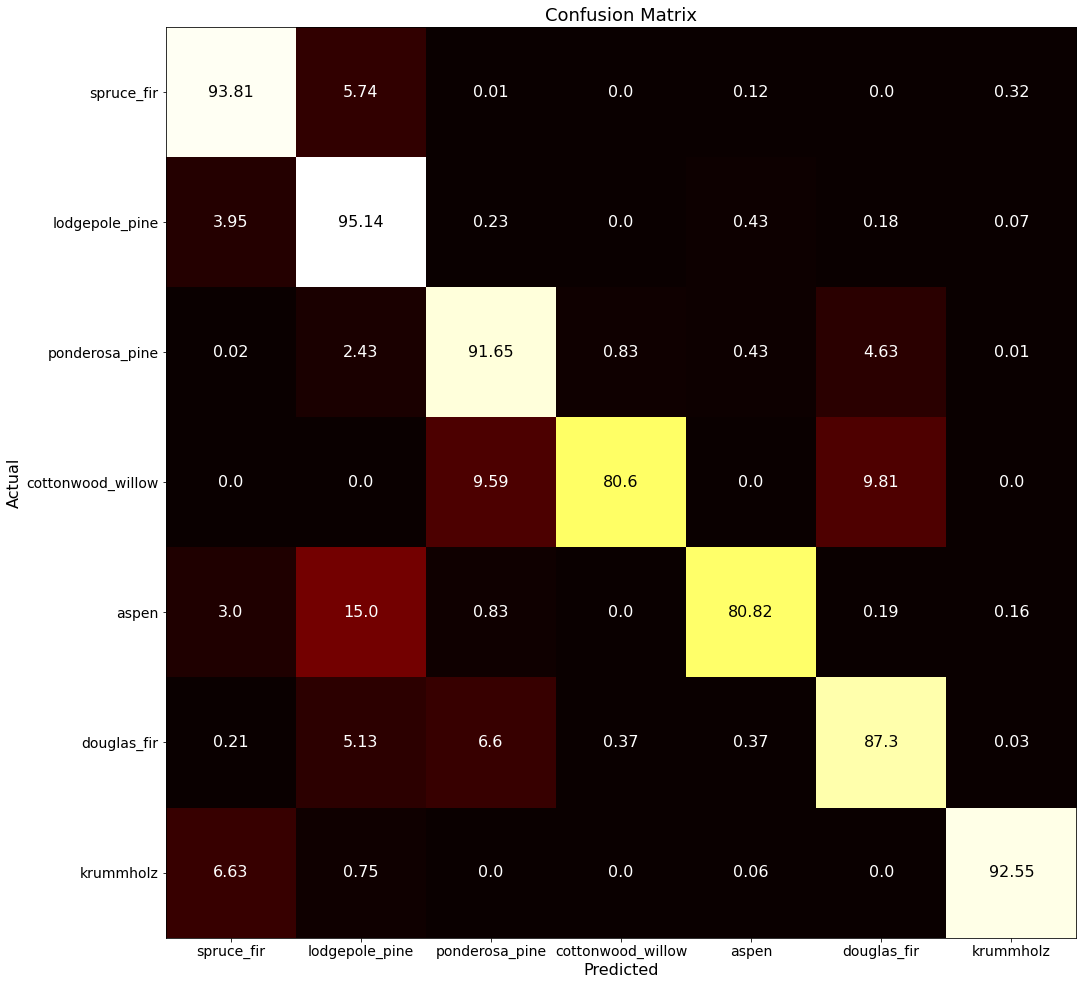

In [9]:
# Plot a confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
im = ax.imshow(percentage_list, cmap="hot")
ax.set_title("Confusion Matrix", fontsize=18)
ax.set_xlabel("Predicted", fontsize=16)
ax.set_xticks(np.arange(len(cover_types)))
ax.set_xticklabels(cover_types, fontsize=14)
ax.set_ylabel("Actual", fontsize=16)
ax.set_yticks(np.arange(len(cover_types)))
ax.set_yticklabels(cover_types, fontsize=14)
for i in range(len(cover_types)):
    for j in range(len(cover_types)):
        percentage = percentage_list[i][j]
        c = "w" if percentage < 35 else "k"
        text = ax.text(j, i, percentage, ha="center", va="center", color=c, fontsize=16)
fig.tight_layout()
plt.show()

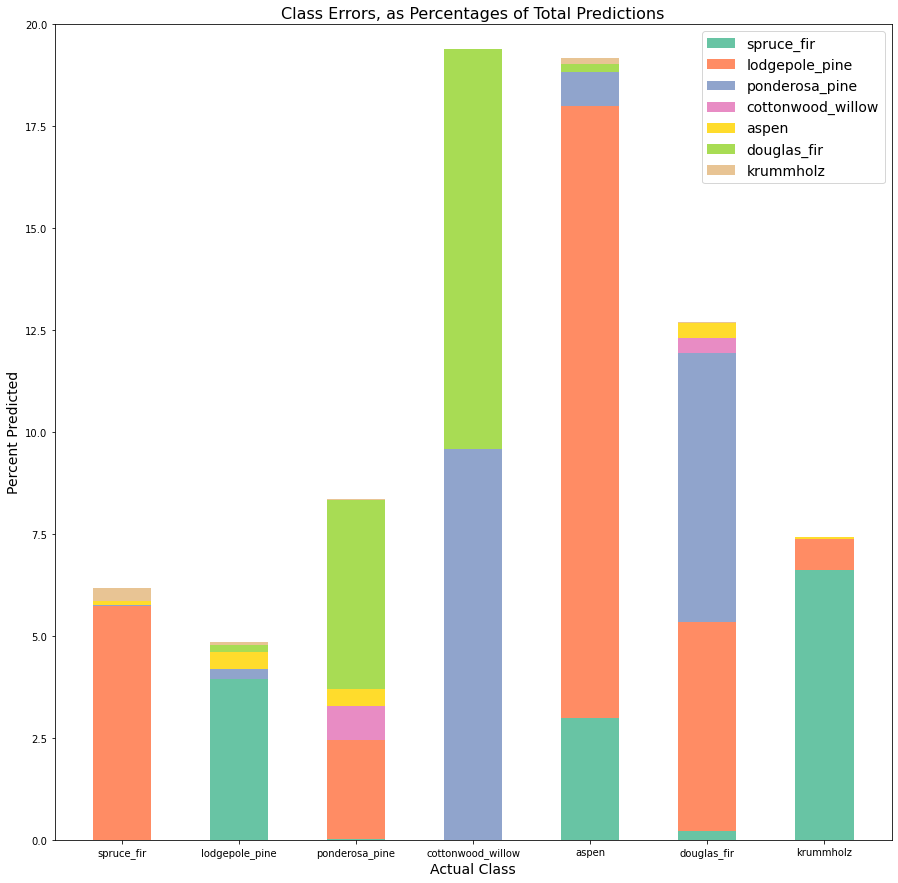

In [10]:
# Class error column chart
fig, ax = plt.subplots(figsize=(15, 15))
offsets = [0.0] * 7
for i in range(len(cover_types)):
    values = []
    for j in range(len(cover_types)):
        if j != i:
            values.append(percentage_list[j][i])
        else:
            values.append(0.0)
    ax.bar(cover_types, values, 0.5, label=cover_types[i], color=color_list[i], bottom=offsets)
    for j in range(len(cover_types)):
        offsets[j] += values[j]

ax.set_title("Class Errors, as Percentages of Total Predictions", fontsize=16)
ax.set_xlabel("Actual Class", fontsize=14)
ax.set_ylabel("Percent Predicted", fontsize=14)
ax.legend(fontsize=14)
plt.ylim([0, 20])
plt.show()

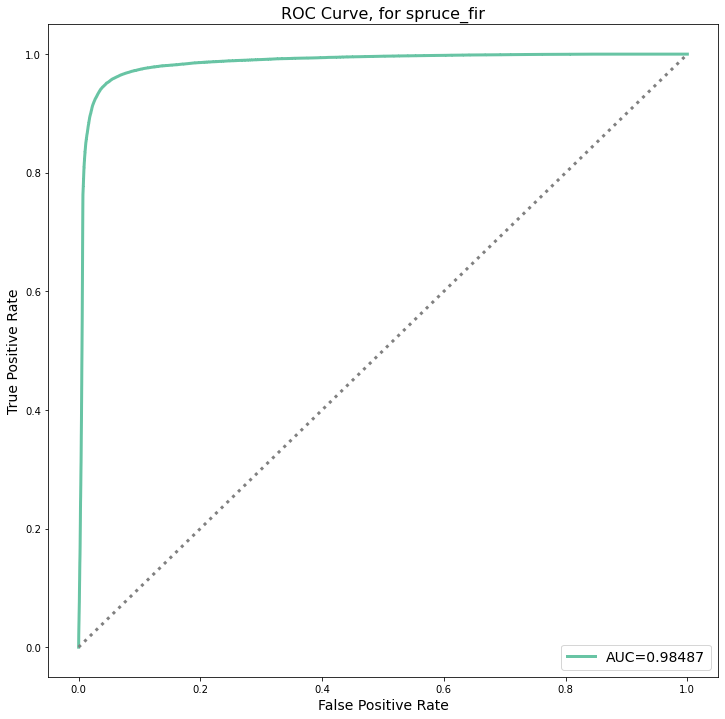

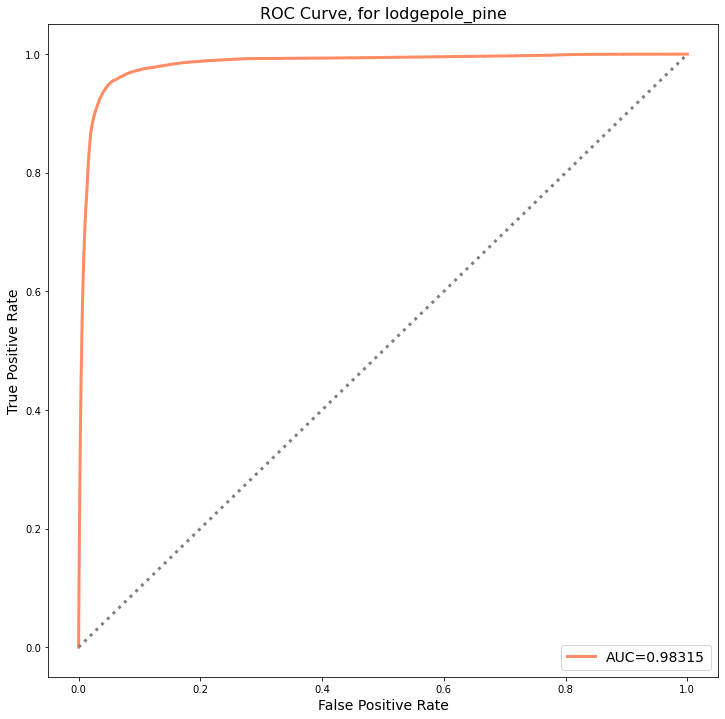

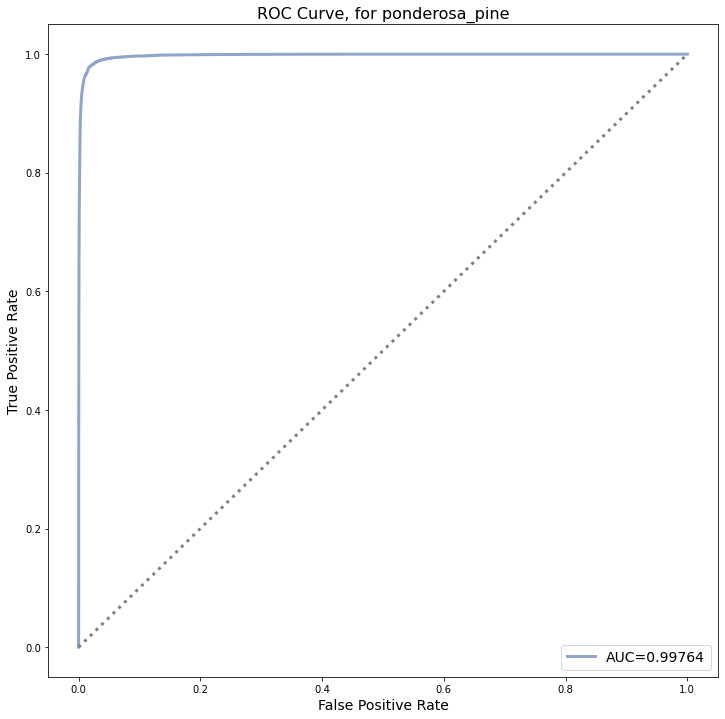

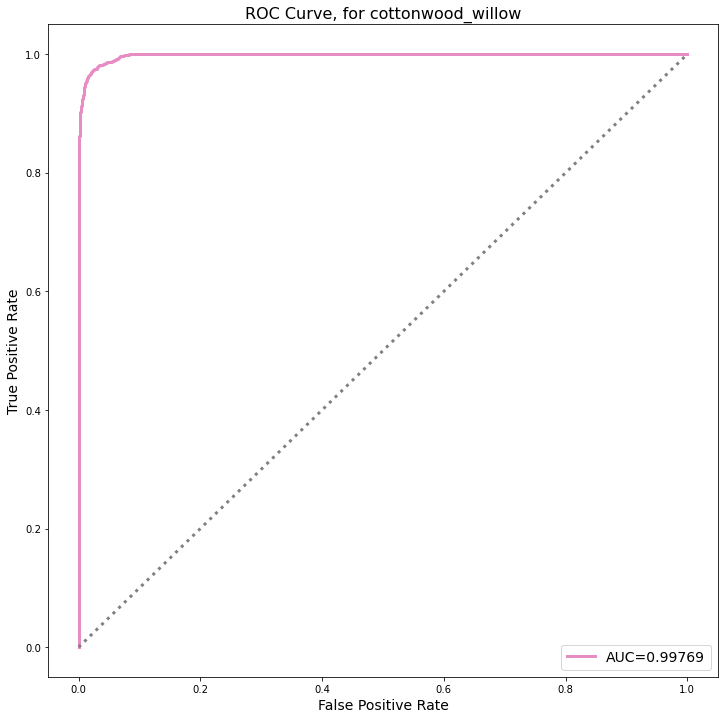

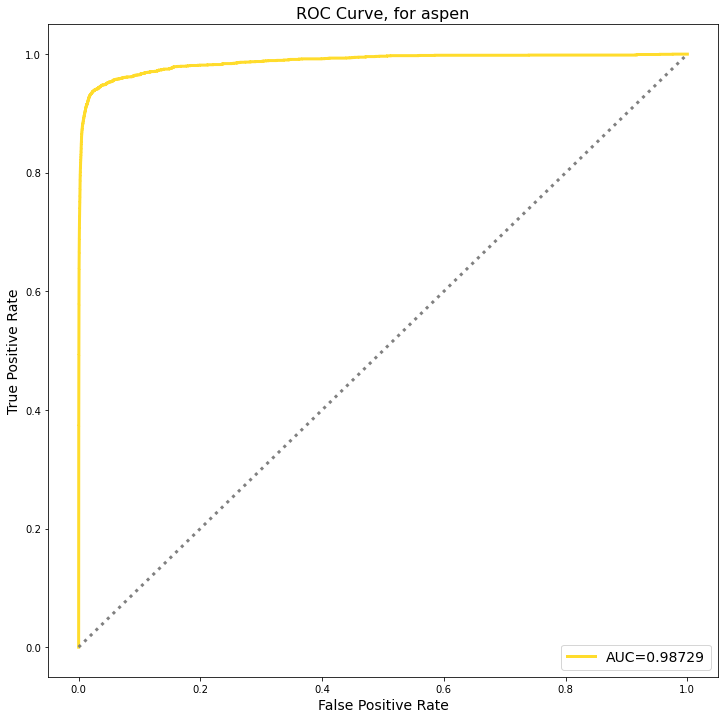

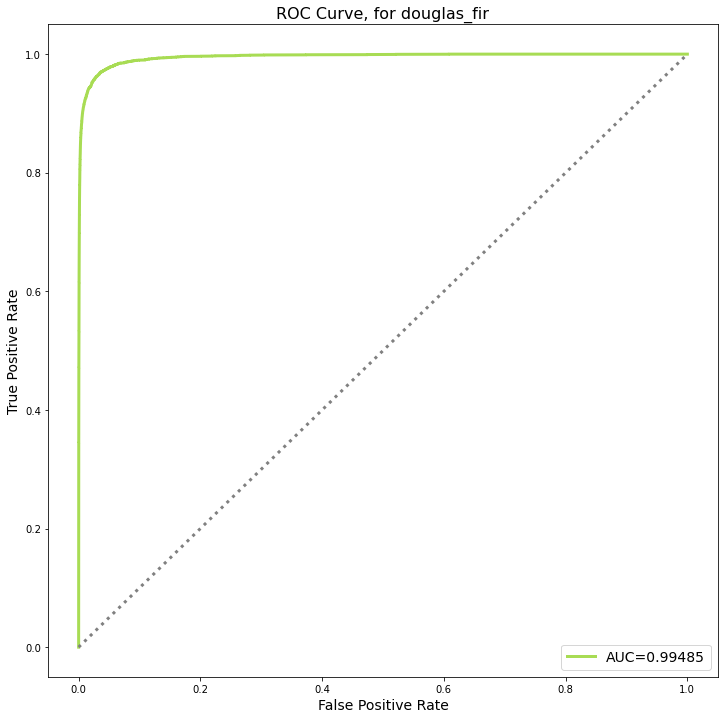

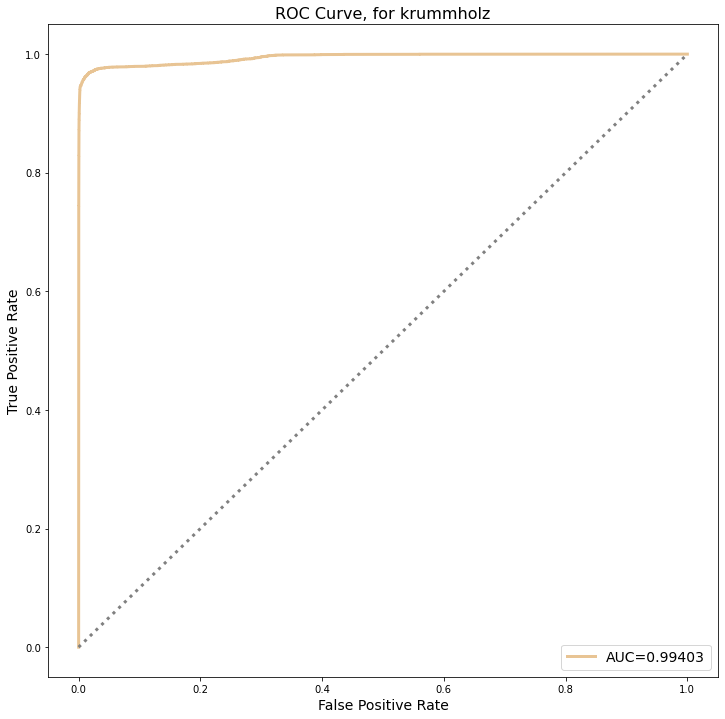

In [11]:
# Plot ROC Curves
for i in range(1, 8):
    i_test = comparison_df["y_test"]
    i_test = [1 if y == i else 0 for y in comparison_df["y_test"]]
    i_probs = comparison_df["prob_" + str(i)]
    
    fpr, tpr, _ = metrics.roc_curve(i_test,  i_probs)
    roc_auc = round(metrics.roc_auc_score(i_test,  i_probs),5)
    
    plt.rcParams["figure.figsize"] = (12,12)
    plt.plot(fpr, tpr, label="AUC="+str(roc_auc), color=color_list[i-1], linewidth=3)
    plt.plot([0, 1], [0,1], color="gray", linewidth=3, linestyle='dotted')
    plt.title("ROC Curve, for {}".format(cover_types[i - 1]), fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()